### with stop command (2-way comm)

In [26]:
import serial
import time
import threading
import ipywidgets as widgets
from IPython.display import display, clear_output

# --- Configuration ---
# !!! IMPORTANT: CHANGE THIS TO YOUR HC-05's ACTUAL COM PORT !!!
COM_PORT = 'COM8' 
BAUD_RATE = 9600  # Must match Arduino's Serial1.begin() baud rate

# --- Global Data Containers for all collected data ---
global_time_data = []
global_rpm_left_data = []
global_pwm_left_data = []
global_rpm_right_data = []
global_pwm_right_data = []

# --- Serial Connection & Threading Control ---
ser = None # Serial object, initialized in acquisition thread
stop_acquisition_flag = threading.Event() # Event to signal stopping the acquisition thread

def send_stop_command():
    """Sends the 'STOP' command over the serial connection."""
    if ser and ser.is_open:
        try:
            ser.write(b"STOP\n") # Send "STOP" followed by a newline
            print("[Sent Command]: STOP")
            ser.close() # <-- This line closes the serial connection
            print("Serial connection to HC-05 closed.")
        except serial.SerialException as e:
            print(f"[ERROR Sending Command]: {e}")
    else:
        print("[ERROR]: Serial port not open to send command. Is Cell 1 running?")

def acquire_data_and_print():
    """Function to run in a separate thread for data acquisition."""
    global ser, global_time_data, global_rpm_left_data, global_pwm_left_data, \
           global_rpm_right_data, global_pwm_right_data # Ensure global scope for lists

    print(f"Attempting to connect to HC-05 on: {COM_PORT} at {BAUD_RATE} baud...")
    try:
        # --- CRITICAL: Clear previous data and reset start_time_ms for each new run ---
        global_time_data.clear()
        global_rpm_left_data.clear()
        global_pwm_left_data.clear()
        global_rpm_right_data.clear()
        global_pwm_right_data.clear()
        start_time_ms_session = 0 # Initialize for the current session

        ser = serial.Serial(COM_PORT, BAUD_RATE, timeout=0.1) # Short timeout for non-blocking read
        print(f"Successfully connected to HC-05 on: {COM_PORT}")
        print("\n--- Starting Data Acquisition ---")
        print("Robot data will be printed below. Use the 'STOP' button to halt motors.")
        print("To stop data collection: Interrupt this cell (square stop button).")
        
        while not stop_acquisition_flag.is_set(): 
            if ser.in_waiting > 0:
                try:
                    line = ser.readline().decode('utf-8').strip()
                    
                    if not line: # Skip empty lines
                        continue

                    # --- REMOVED: print(f"Arduino Raw: {line}") ---

                    # Try to parse as data line (Timestamp,RPM_L,PWM_L,RPM_R,PWM_R)
                    parts = line.split(',')
                    if len(parts) == 5:
                        try:
                            timestamp_ms = int(parts[0])
                            rpm_l = float(parts[1])
                            pwm_l = int(parts[2])
                            rpm_r = float(parts[3])
                            pwm_r = int(parts[4])

                            if start_time_ms_session == 0: # Set initial timestamp for relative time
                                start_time_ms_session = timestamp_ms

                            relative_time_ms = timestamp_ms - start_time_ms_session

                            # Append data to global lists
                            global_time_data.append(relative_time_ms)
                            global_rpm_left_data.append(rpm_l)
                            global_pwm_left_data.append(pwm_l)
                            global_rpm_right_data.append(rpm_r)
                            global_pwm_right_data.append(pwm_r)

                            # Print formatted data (if successfully parsed)
                            print(f"Parsed Data: {relative_time_ms},{rpm_l:.2f},{pwm_l},{rpm_r:.2f},{pwm_r}")

                        except ValueError as ve:
                            print(f"Error parsing values in line: '{line}' - {ve}")
                        except IndexError:
                            print(f"Incomplete line received: '{line}'")
                    else:
                        # If it's not a 5-part data line, print it as an "Arduino Raw" debug message (now only for unexpected format)
                        print(f"Arduino Unexpected Raw: {line}")


                except UnicodeDecodeError as ude:
                    print(f"UnicodeDecodeError: {ude} - Problematic bytes: {ser.readline()}")
                except Exception as e:
                    print(f"An unexpected error occurred during data processing: {e}")
                    
            time.sleep(0.01) # Small delay to avoid busy-waiting

    except serial.SerialException as e:
        print(f"\nSerial port error: {e}")
        print(f"Please ensure {COM_PORT} is the correct port and it's not already in use.")
        print("Ensure HC-05 is powered, paired, and its 'Serial Port (SPP)' service is enabled in 'Devices and Printers'.")
    except KeyboardInterrupt: # This block might not be hit if thread handles it
        print("\n--- Data collection interrupted (Ctrl+C). ---")
    finally:
        if ser and ser.is_open:
            ser.close()
            print("Serial port closed.")
        print(f"Collected {len(global_time_data)} data points.")
        print("\nProceed to the next cell if needed (though not provided in this simplified version).")


# --- Jupyter Widget for STOP Command ---
stop_button = widgets.Button(
    description='STOP ROBOT',
    disabled=False,
    button_style='danger', # Red button for danger!
    tooltip='Click to immediately stop robot motors',
    icon='stop'
)

output_widget = widgets.Output() # To display output from button click

def on_stop_button_click(b):
    with output_widget:
        clear_output() # Clear previous button output
        send_stop_command()

stop_button.on_click(on_stop_button_click)

# --- Start the Acquisition Thread and Display Widgets ---
if __name__ == '__main__':
    # Ensure previous acquisition is stopped if cell is re-run
    stop_acquisition_flag.set() # Set flag to stop any old thread
    time.sleep(0.1) # Give it a moment to stop
    stop_acquisition_flag.clear() # Clear flag for new run

    acquisition_thread = threading.Thread(target=acquire_data_and_print)
    acquisition_thread.daemon = True # Allows Jupyter to close even if thread is active
    acquisition_thread.start()

    # Display the widget button immediately in the cell output
    display(widgets.VBox([stop_button, output_widget]))

Attempting to connect to HC-05 on: COM8 at 9600 baud...


Successfully connected to HC-05 on: COM8

--- Starting Data Acquisition ---
Robot data will be printed below. Use the 'STOP' button to halt motors.
To stop data collection: Interrupt this cell (square stop button).
Arduino Unexpected Raw: 14999,0.00,255,0.00,255,0.00
Arduino Unexpected Raw: 15199,56.25,232,75.00,165,48.10
Arduino Unexpected Raw: 15399,93.75,206,93.75,148,116.82
Arduino Unexpected Raw: 15599,93.75,195,75.00,235,178.67
Arduino Unexpected Raw: 15799,93.75,195,75.00,246,240.52
Arduino Unexpected Raw: 16000,74.63,225,74.63,255,295.49
Arduino Unexpected Raw: 16200,112.50,93,93.75,104,371.08
Arduino Unexpected Raw: 16400,93.75,100,112.50,85,446.67
Arduino Unexpected Raw: 16600,56.25,149,56.25,180,487.90
Arduino Unexpected Raw: 16800,75.00,130,75.00,152,542.88
Arduino Unexpected Raw: 17000,75.00,101,75.00,85,597.85
Arduino Unexpected Raw: 17200,56.25,119,56.25,113,639.08
Arduino Unexpected Raw: 17400,56.25,119,75.00,85,687.19
Arduino Unexpected Raw: 17600,56.25,119,37.50,152,7

Plotting 59 data points...


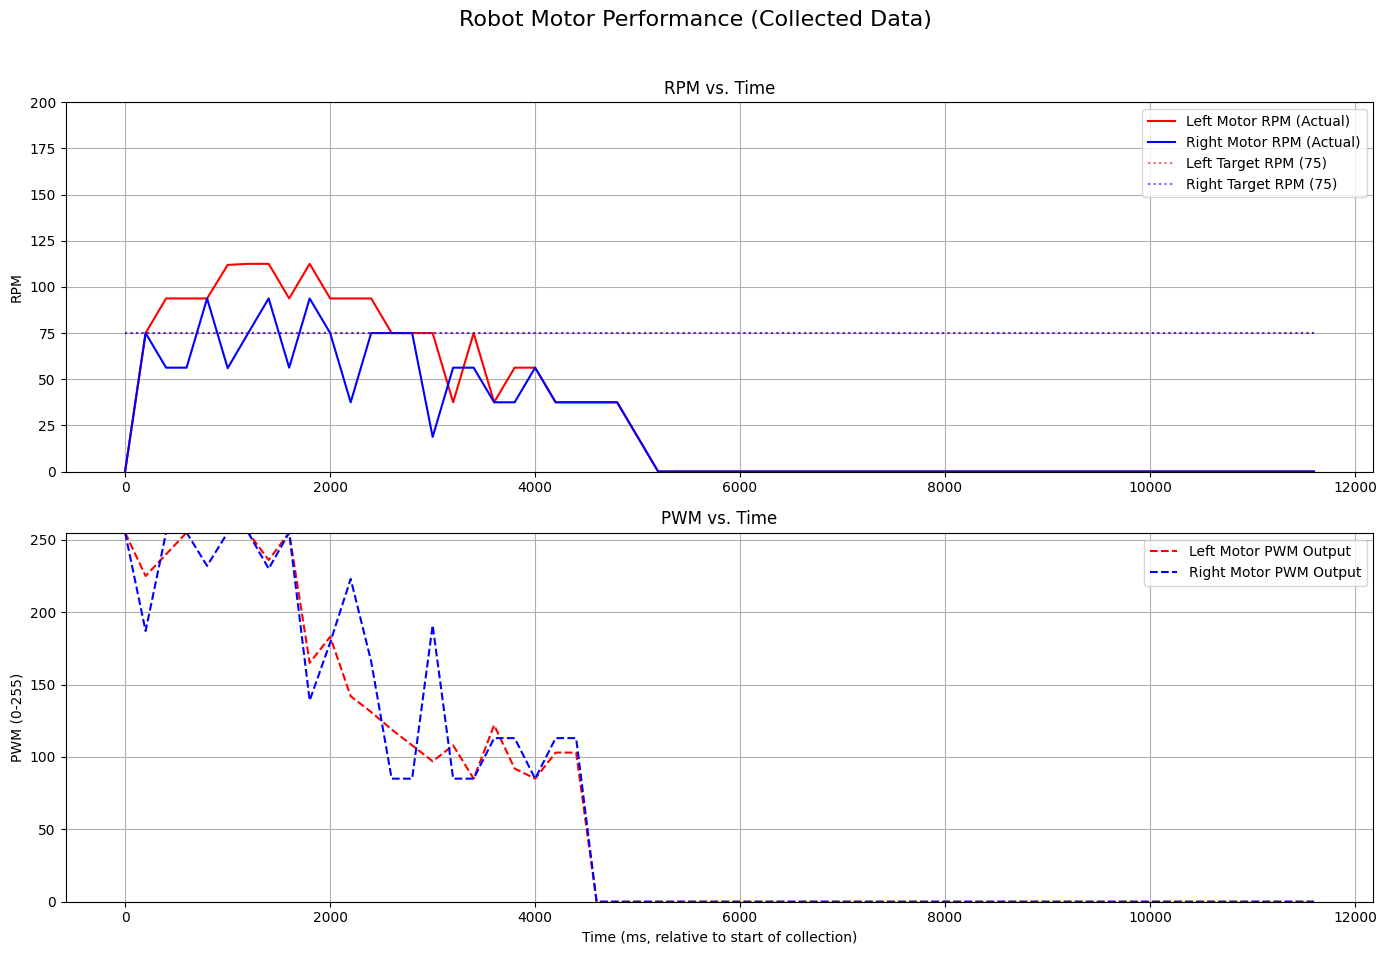

Estimated distance covered: 1323.77 mm


In [39]:
import matplotlib.pyplot as plt
import numpy as np

# --- Retrieve Data from Global Variables (Populated by Cell 1) ---
# Ensure Cell 1 has been run and data has been collected
if not global_time_data:
    print("No data collected. Please run Cell 1 (Data Acquisition) first and let it collect some data.")
else:
    print(f"Plotting {len(global_time_data)} data points...")

    # Convert global lists to numpy arrays for efficient plotting
    plot_time = np.array(global_time_data)
    plot_rpm_left = np.array(global_rpm_left_data)
    plot_pwm_left = np.array(global_pwm_left_data)
    plot_rpm_right = np.array(global_rpm_right_data)
    plot_pwm_right = np.array(global_pwm_right_data)

    # --- Plot Setup ---
    plt.ioff() # Ensure interactive mode is off for static plot
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10)) # Adjusted figure size for better visibility
    fig.suptitle('Robot Motor Performance (Collected Data)', fontsize=16)

    # Plot RPMs
    ax1.plot(plot_time, plot_rpm_left, 'r-', label='Left Motor RPM (Actual)')
    ax1.plot(plot_time, plot_rpm_right, 'b-', label='Right Motor RPM (Actual)')
    
    # Add target RPM lines for reference (assuming target is 75 RPM, as per Arduino code)
    if plot_time.size > 0:
        ax1.plot(plot_time, np.full_like(plot_time, 75.0), 'r:', alpha=0.6, label='Left Target RPM (75)')
        ax1.plot(plot_time, np.full_like(plot_time, 75.0), 'b:', alpha=0.6, label='Right Target RPM (75)')

    ax1.set_ylabel('RPM')
    ax1.set_title('RPM vs. Time')
    ax1.legend()
    ax1.grid(True)
    ax1.set_ylim(0, 200) # Adjust Y-limit for RPM if your target/actual RPM differs significantly

    # Plot PWMs
    ax2.plot(plot_time, plot_pwm_left, 'r--', label='Left Motor PWM Output')
    ax2.plot(plot_time, plot_pwm_right, 'b--', label='Right Motor PWM Output')

    ax2.set_xlabel('Time (ms, relative to start of collection)')
    ax2.set_ylabel('PWM (0-255)')
    ax2.set_title('PWM vs. Time')
    ax2.legend()
    ax2.grid(True)
    ax2.set_ylim(0, 255) # PWM range is 0-255

    plt.tight_layout(rect=[0, 0.03, 1, 0.96]) # Adjust layout to prevent title overlap
    plt.show()

    runtime_sec = plot_time[-1] / 1000.0
    avg_rpm_left = np.mean(plot_rpm_left)
    revolutions = avg_rpm_left * runtime_sec / 60.0
    distance_mm = revolutions * 219.9
    print(f"Estimated distance covered: {distance_mm:.2f} mm")


## for position

In [12]:
import serial
import time
import threading
import ipywidgets as widgets
from IPython.display import display, clear_output

# --- Configuration ---
# !!! IMPORTANT: CHANGE THIS TO YOUR HC-05's ACTUAL COM PORT !!!
COM_PORT = 'COM8' 
BAUD_RATE = 9600  # Must match Arduino's Serial1.begin() baud rate

# --- Global Data Containers for all collected data ---
global_time_data = []
global_rpm_left_data = []
global_pwm_left_data = []
global_rpm_right_data = []
global_pwm_right_data = []
global_dist_data = []

# --- Serial Connection & Threading Control ---
ser = None # Serial object, initialized in acquisition thread
stop_acquisition_flag = threading.Event() # Event to signal stopping the acquisition thread

def send_stop_command():
    """Sends the 'STOP' command over the serial connection."""
    if ser and ser.is_open:
        try:
            ser.write(b"STOP\n") # Send "STOP" followed by a newline
            print("[Sent Command]: STOP")
            ser.close() # <-- This line closes the serial connection
            print("Serial connection to HC-05 closed.")
        except serial.SerialException as e:
            print(f"[ERROR Sending Command]: {e}")
    else:
        print("[ERROR]: Serial port not open to send command. Is Cell 1 running?")

def acquire_data_and_print():
    """Function to run in a separate thread for data acquisition."""
    global ser, global_time_data, global_rpm_left_data, global_pwm_left_data, \
           global_rpm_right_data, global_pwm_right_data, global_dist_data # Ensure global scope for lists

    print(f"Attempting to connect to HC-05 on: {COM_PORT} at {BAUD_RATE} baud...")
    try:
        # --- CRITICAL: Clear previous data and reset start_time_ms for each new run ---
        global_time_data.clear()
        global_rpm_left_data.clear()
        global_pwm_left_data.clear()
        global_rpm_right_data.clear()
        global_pwm_right_data.clear()
        global_dist_data.clear()
        start_time_ms_session = 0 # Initialize for the current session

        ser = serial.Serial(COM_PORT, BAUD_RATE, timeout=0.1) # Short timeout for non-blocking read
        print(f"Successfully connected to HC-05 on: {COM_PORT}")
        print("\n--- Starting Data Acquisition ---")
        print("Robot data will be printed below. Use the 'STOP' button to halt motors.")
        print("To stop data collection: Interrupt this cell (square stop button).")
        
        while not stop_acquisition_flag.is_set(): 
            if ser.in_waiting > 0:
                try:
                    line = ser.readline().decode('utf-8').strip()
                    
                    if not line: # Skip empty lines
                        continue

                    # --- REMOVED: print(f"Arduino Raw: {line}") ---

                    # Try to parse as data line (Timestamp,RPM_L,PWM_L,RPM_R,PWM_R)
                    parts = line.split(',')
                    if len(parts) == 6:
                        try:
                            timestamp_ms = int(parts[0])
                            rpm_l = float(parts[1])
                            pwm_l = int(parts[2])
                            rpm_r = float(parts[3])
                            pwm_r = int(parts[4])
                            dist = float(parts[5])

                            if start_time_ms_session == 0: # Set initial timestamp for relative time
                                start_time_ms_session = timestamp_ms

                            relative_time_ms = timestamp_ms - start_time_ms_session

                            # Append data to global lists
                            global_time_data.append(relative_time_ms)
                            global_rpm_left_data.append(rpm_l)
                            global_pwm_left_data.append(pwm_l)
                            global_rpm_right_data.append(rpm_r)
                            global_pwm_right_data.append(pwm_r)
                            global_dist_data.append(dist)

                            # Print formatted data (if successfully parsed)
                            print(f"Parsed Data: {relative_time_ms},{rpm_l:.2f},{pwm_l},{rpm_r:.2f},{pwm_r},{dist}")

                        except ValueError as ve:
                            print(f"Error parsing values in line: '{line}' - {ve}")
                        except IndexError:
                            print(f"Incomplete line received: '{line}'")
                    else:
                        # If it's not a 5-part data line, print it as an "Arduino Raw" debug message (now only for unexpected format)
                        print(f"Arduino Unexpected Raw: {line}")


                except UnicodeDecodeError as ude:
                    print(f"UnicodeDecodeError: {ude} - Problematic bytes: {ser.readline()}")
                except Exception as e:
                    print(f"An unexpected error occurred during data processing: {e}")
                    
            time.sleep(0.01) # Small delay to avoid busy-waiting

    except serial.SerialException as e:
        print(f"\nSerial port error: {e}")
        print(f"Please ensure {COM_PORT} is the correct port and it's not already in use.")
        print("Ensure HC-05 is powered, paired, and its 'Serial Port (SPP)' service is enabled in 'Devices and Printers'.")
    except KeyboardInterrupt: # This block might not be hit if thread handles it
        print("\n--- Data collection interrupted (Ctrl+C). ---")
    finally:
        if ser and ser.is_open:
            ser.close()
            print("Serial port closed.")
        print(f"Collected {len(global_time_data)} data points.")
        print("\nProceed to the next cell if needed (though not provided in this simplified version).")


# --- Jupyter Widget for STOP Command ---
stop_button = widgets.Button(
    description='STOP ROBOT',
    disabled=False,
    button_style='danger', # Red button for danger!
    tooltip='Click to immediately stop robot motors',
    icon='stop'
)

output_widget = widgets.Output() # To display output from button click

def on_stop_button_click(b):
    with output_widget:
        clear_output() # Clear previous button output
        send_stop_command()

stop_button.on_click(on_stop_button_click)

# --- Start the Acquisition Thread and Display Widgets ---
if __name__ == '__main__':
    # Ensure previous acquisition is stopped if cell is re-run
    stop_acquisition_flag.set() # Set flag to stop any old thread
    time.sleep(0.1) # Give it a moment to stop
    stop_acquisition_flag.clear() # Clear flag for new run

    acquisition_thread = threading.Thread(target=acquire_data_and_print)
    acquisition_thread.daemon = True # Allows Jupyter to close even if thread is active
    acquisition_thread.start()

    # Display the widget button immediately in the cell output
    display(widgets.VBox([stop_button, output_widget]))

Attempting to connect to HC-05 on: COM8 at 9600 baud...



Serial port error: could not open port 'COM8': OSError(22, 'The semaphore timeout period has expired.', None, 121)
Please ensure COM8 is the correct port and it's not already in use.
Ensure HC-05 is powered, paired, and its 'Serial Port (SPP)' service is enabled in 'Devices and Printers'.
Collected 0 data points.

Proceed to the next cell if needed (though not provided in this simplified version).


Plotting 40 data points...


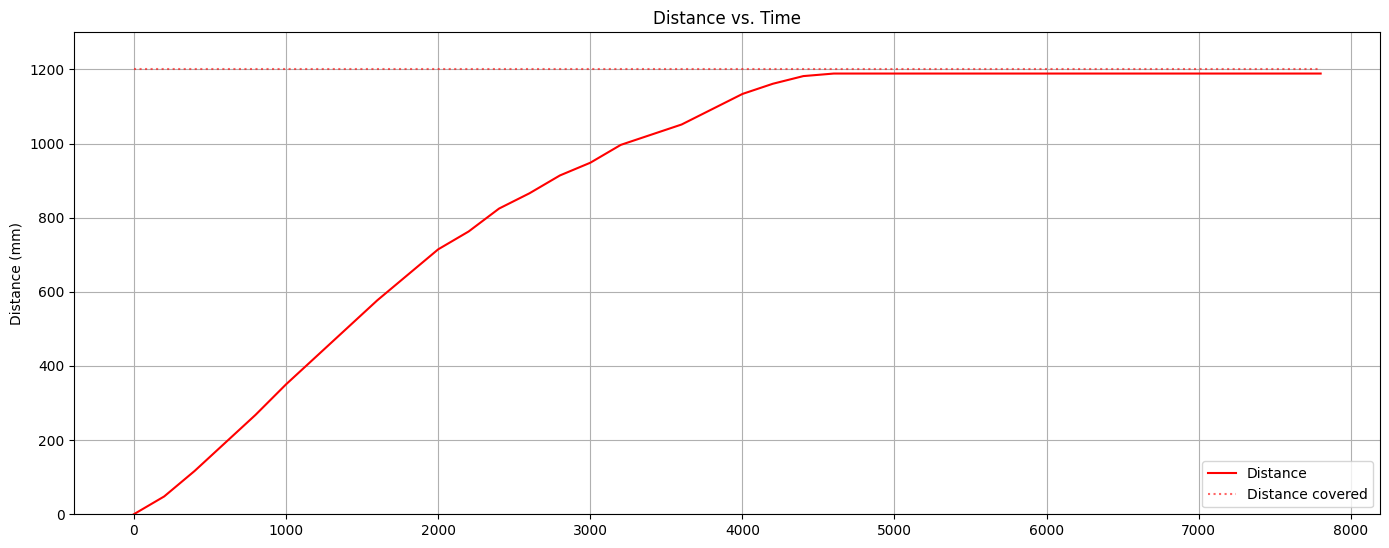

Estimated distance covered: 1178.96 mm


In [6]:
import matplotlib.pyplot as plt
import numpy as np

# --- Retrieve Data from Global Variables (Populated by Cell 1) ---
# Ensure Cell 1 has been run and data has been collected
if not global_time_data:
    print("No data collected. Please run Cell 1 (Data Acquisition) first and let it collect some data.")
else:
    print(f"Plotting {len(global_time_data)} data points...")

    # Convert global lists to numpy arrays for efficient plotting
    plot_time = np.array(global_time_data)
    plot_rpm_left = np.array(global_rpm_left_data)
    plot_pwm_left = np.array(global_pwm_left_data)
    plot_rpm_right = np.array(global_rpm_right_data)
    plot_pwm_right = np.array(global_pwm_right_data)
    plot_dist = np.array(global_dist_data)

    # --- Plot Setup ---
    plt.ioff() # Ensure interactive mode is off for static plot
    fig, ax = plt.subplots(1, 1, figsize=(14, 6)) # Adjusted figure size for better visibility

    # Plot RPMs
    ax.plot(plot_time, plot_dist, 'r-', label='Distance')
    
    # Add target RPM lines for reference (assuming target is 75 RPM, as per Arduino code)
    if plot_time.size > 0:
        ax.plot(plot_time, np.full_like(plot_time, 1200.0), 'r:', alpha=0.6, label='Distance covered')

    ax.set_ylabel('Distance (mm)')
    ax.set_title('Distance vs. Time')
    ax.legend()
    ax.grid(True)
    ax.set_ylim(0, 1300) # Adjust Y-limit for RPM if your target/actual RPM differs significantly


    plt.tight_layout(rect=[0, 0.03, 1, 0.96]) # Adjust layout to prevent title overlap
    plt.show()

    runtime_sec = plot_time[-1] / 1000.0
    avg_rpm_left = np.mean(plot_rpm_left)
    revolutions = avg_rpm_left * runtime_sec / 60.0
    distance_mm = revolutions * 219.9
    print(f"Estimated distance covered: {distance_mm:.2f} mm")
